In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt

from mpi4py import MPI
from dolfinx import mesh, fem, io
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import ufl
from petsc4py import PETSc
import meshio
import os
from dolfinx.io import VTXWriter

In [2]:
# ==========================
# GEOMETRY PARAMETERS (cm)
# ==========================

# Arch parameters from drawing
R_top = 21.29         # outer radius to top surface
t_arc = 0.29          # arch thickness (normal to curvature)
offset_mid = 1  # vertical offset of arch mid-thickness above block bottom

# Span from arch center to block inner face
L_half = 5.5          # 55 mm

# Block geometry
block_width  = 2.0    # cm
block_height = 1.7    # cm

# Tangent angles at arch start (degrees)
angle_left_deg  = 90.0   # horizontal entering block
angle_right_deg = 99.0   # rotated downward

# Clearance between block face and arch arc start (2 mm)
clearance = 0.2      # 0.2 cm (2 mm)

# Mesh fineness
mesh_size = 0.15      # global gmsh target mesh size (cm)


# ==========================
# MATERIAL (hyperelastic)
# ==========================
E  = 1e6
nu = 0.3
mu = E / (2*(1+nu))
lmbda = E*nu / ((1+nu)*(1-2*nu))


# ==========================
# LOADING
# ==========================
U_total = 0.4         # total relative separation (cm)
n_steps = 10          # load steps


# Mesh sizes (cm)
mesh_size_arch  = 0.08   # fine near the arch curves
mesh_size_block = 0.25   # coarser in the blocks / away from arch


arch_bottom_y = 0.71   # cm, 7.1 mm above block bottom

In [3]:

gmsh.initialize()
gmsh.model.add("arch_block_system")

# -------------------------
# Geometry from drawing (all in cm)
# -------------------------
R_top        = 21.29      # top arch radius  (R212.9)
R_bot        = 21.0       # bottom arch radius (R210)
t_arc        = R_top - R_bot  # arch thickness (~0.29 cm = 2.9 mm)

L_half       = 5.5        # centerline to inner face of block (55 mm)
block_width  = 2.0        # block width  (20 mm)
block_height = 1.7        # block height (17 mm)

arch_bottom_y = 0.71      # bottom of arch is 7.1 mm above block bottom

# Mesh sizes
mesh_size_arch  = 0.10
mesh_size_block = 0.25

# -------------------------
# Circle center and angle
# Bottom arch (R_bot) must pass through (±L_half, arch_bottom_y)
# -------------------------
phi = np.arcsin(L_half / R_bot)                    # half-angle from vertical (use R_bot)
c   = arch_bottom_y - R_bot * np.cos(phi)          # y-coordinate of circle center

print(f"circle center y = {c:.3f} cm, "
      f"inner arch bottom y = {arch_bottom_y:.3f} cm, "
      f"phi = {phi*180/np.pi:.2f} deg")

def circle_point(r, beta):
    """Point on circle of radius r at angle beta (from vertical), center (0, c)."""
    x = r * np.sin(beta)
    y = c + r * np.cos(beta)
    return x, y, 0.0

# -------------------------
# Define arch points (top & bottom surfaces)
# -------------------------
p_center = gmsh.model.occ.addPoint(0.0, c, 0.0, mesh_size_arch)

# Bottom (inner) arch endpoints at x = ±L_half, y = arch_bottom_y
p_bot_L = gmsh.model.occ.addPoint(*circle_point(R_bot, -phi), mesh_size_arch)
p_bot_R = gmsh.model.occ.addPoint(*circle_point(R_bot,  phi), mesh_size_arch)

# Top (outer) arch endpoints at same angles, radius R_top
p_top_L = gmsh.model.occ.addPoint(*circle_point(R_top, -phi), mesh_size_arch)
p_top_R = gmsh.model.occ.addPoint(*circle_point(R_top,  phi), mesh_size_arch)

# -------------------------
# Arcs and radial lines (annular arch)
# -------------------------
top_arc  = gmsh.model.occ.addCircleArc(p_top_L, p_center, p_top_R)
bot_arc  = gmsh.model.occ.addCircleArc(p_bot_R, p_center, p_bot_L)  # reversed for loop
left_rad = gmsh.model.occ.addLine(p_top_L, p_bot_L)
right_rad= gmsh.model.occ.addLine(p_top_R, p_bot_R)

arch_loop = gmsh.model.occ.addCurveLoop([top_arc, right_rad, bot_arc, left_rad])
arch_surf = gmsh.model.occ.addPlaneSurface([arch_loop])

# -------------------------
# Blocks (rectangles)
# -------------------------
xL_inner = -L_half
xR_inner =  L_half
y0 = 0.0
y1 = block_height

left_block  = gmsh.model.occ.addRectangle(xL_inner - block_width, y0, 0.0,
                                          block_width, block_height)
right_block = gmsh.model.occ.addRectangle(xR_inner, y0, 0.0,
                                          block_width, block_height)

# -------------------------
# Fuse arch + blocks into one solid
# -------------------------
gmsh.model.occ.synchronize()
gmsh.model.occ.fuse([(2, arch_surf)],
                    [(2, left_block), (2, right_block)])
gmsh.model.occ.removeAllDuplicates()
gmsh.model.occ.synchronize()

# -------------------------
# Mesh controls
# -------------------------
gmsh.option.setNumber("Mesh.MeshSizeMin", mesh_size_arch)
gmsh.option.setNumber("Mesh.MeshSizeMax", mesh_size_block)
gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 1)
gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 1)

# -------------------------
# Physical group for domain (for dolfinx)
# -------------------------
surfaces = gmsh.model.getEntities(dim=2)
surf_tags = [s[1] for s in surfaces]
gmsh.model.addPhysicalGroup(2, surf_tags, 1)
gmsh.model.setPhysicalName(2, 1, "Domain")

# -------------------------
# Mesh + write
# -------------------------
gmsh.model.mesh.generate(2)
gmsh.write("arch_blocks.msh")
gmsh.finalize()

print("Mesh written to arch_blocks.msh")


circle center y = -19.557 cm, inner arch bottom y = 0.710 cm, phi = 15.18 deg
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Circle)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Circle)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : [ 90%] Meshing curve 15 (Circle)
Info    : [100%] Meshing curve 16 (Circle)
Info    : Done meshing 1D (Wall 0.00690942s, CPU 0.0073s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 3 (Pla

In [4]:
domain, ct, ft = io.gmshio.read_from_msh("arch_blocks.msh", MPI.COMM_WORLD, 0, gdim=2)
V = fem.VectorFunctionSpace(domain, ("CG", 1))
#V = fem.FunctionSpace(domain, ("CG", 1, 2))

coords = domain.geometry.x
coords_ref = coords.copy()
domain.topology.create_connectivity(2, 0)
cells = domain.topology.connectivity(2, 0).array.reshape(-1, 3)

print("Imported mesh:")
print("  Num cells:", domain.topology.index_map(2).size_local)
print("  Num vertices:", domain.topology.index_map(0).size_local)


tdim = domain.topology.dim
gdim = domain.geometry.dim

# Original coordinates (N, 3)
coords_ref = domain.geometry.x.copy()

# Triangle connectivity (M, 3)
domain.topology.create_connectivity(tdim, 0)
cells_tri = domain.topology.connectivity(tdim, 0).array.reshape(-1, 3)

# Keep this for plot_deformed
cells = cells_tri


Info    : Reading 'arch_blocks.msh'...
Info    : 34 entities
Info    : 521 nodes
Info    : 823 elements
Info    : Done reading 'arch_blocks.msh'


  V = fem.VectorFunctionSpace(domain, ("CG", 1))



Imported mesh:
  Num cells: 823
  Num vertices: 521


In [5]:
# Precompute reference coordinates and cell connectivity
coords_ref = domain.geometry.x.copy()
tdim = domain.topology.dim
domain.topology.create_connectivity(tdim, 0)
cells = domain.topology.connectivity(tdim, 0).array.reshape(-1, 3)
num_cells = cells.shape[0]
num_points = coords_ref.shape[0]

# VTK cell type for triangle is 5
cell_types = np.full(num_cells, 5, dtype=np.uint8)

def write_vtu_with_u(filename, coords_def, u_vals):
    """
    coords_def: (N,3) deformed coordinates (x,y,z)
    u_vals:     (N,2) displacement values (ux,uy)
    """
    N = coords_def.shape[0]
    M = cells.shape[0]

    # Pad displacement to 3D: uz = 0
    u_3d = np.column_stack([u_vals, np.zeros(N)])

    # connectivity and offsets
    connectivity = cells.flatten()
    offsets = 3 * (np.arange(M) + 1)

    with open(filename, "w") as f:
        f.write('<?xml version="1.0"?>\n')
        f.write('<VTKFile type="UnstructuredGrid" version="0.1" byte_order="LittleEndian">\n')
        f.write('  <UnstructuredGrid>\n')
        f.write(f'    <Piece NumberOfPoints="{N}" NumberOfCells="{M}">\n')

        # Points (already 3D)
        f.write('      <Points>\n')
        f.write('        <DataArray type="Float32" NumberOfComponents="3" format="ascii">\n')
        for x, y, z in coords_def:
            f.write(f"          {x:.8e} {y:.8e} {z:.8e}\n")
        f.write('        </DataArray>\n')
        f.write('      </Points>\n')

        # Cells
        f.write('      <Cells>\n')
        f.write('        <DataArray type="Int32" Name="connectivity" format="ascii">\n')
        for v in connectivity:
            f.write(f"          {int(v)}\n")
        f.write('        </DataArray>\n')

        f.write('        <DataArray type="Int32" Name="offsets" format="ascii">\n')
        for off in offsets:
            f.write(f"          {int(off)}\n")
        f.write('        </DataArray>\n')

        f.write('        <DataArray type="UInt8" Name="types" format="ascii">\n')
        for ct in cell_types:
            f.write(f"          {int(ct)}\n")
        f.write('        </DataArray>\n')
        f.write('      </Cells>\n')

        # Point data: displacement vector u
        f.write('      <PointData Vectors="u">\n')
        f.write('        <DataArray type="Float32" Name="u" NumberOfComponents="3" format="ascii">\n')
        for ux, uy, uz in u_3d:
            f.write(f"          {ux:.8e} {uy:.8e} {uz:.8e}\n")
        f.write('        </DataArray>\n')
        f.write('      </PointData>\n')

        f.write('    </Piece>\n')
        f.write('  </UnstructuredGrid>\n')
        f.write('</VTKFile>\n')


In [6]:
# Left block outer face = min x
# Right block outer face = max x

x_min = np.min(coords_ref[:, 0])
x_max = np.max(coords_ref[:, 0])
tol = 1e-6

def left_face(x):
    return np.isclose(x[0], x_min, atol=tol)

def right_face(x):
    return np.isclose(x[0], x_max, atol=tol)

facets_left  = mesh.locate_entities_boundary(domain, 1, left_face)
facets_right = mesh.locate_entities_boundary(domain, 1, right_face)

dofs_left_x  = fem.locate_dofs_topological(V.sub(0), 1, facets_left)
dofs_left_y  = fem.locate_dofs_topological(V.sub(1), 1, facets_left)
dofs_right_x = fem.locate_dofs_topological(V.sub(0), 1, facets_right)
dofs_right_y = fem.locate_dofs_topological(V.sub(1), 1, facets_right)

# Block vertical movement blocked (optional)
zero_y = fem.Constant(domain, 0.0)

# Horizontal BCs to be updated during load
u_left_x  = fem.Constant(domain, PETSc.ScalarType(0.0))
u_right_x = fem.Constant(domain, PETSc.ScalarType(0.0))

bc_left_x  = fem.dirichletbc(u_left_x,  dofs_left_x,  V.sub(0))
bc_right_x = fem.dirichletbc(u_right_x, dofs_right_x, V.sub(0))
bc_left_y  = fem.dirichletbc(zero_y,    dofs_left_y,  V.sub(1))
bc_right_y = fem.dirichletbc(zero_y,    dofs_right_y, V.sub(1))

bcs = [bc_left_x, bc_right_x, bc_left_y, bc_right_y]

print("Boundary DOFs assigned.")


Boundary DOFs assigned.


In [7]:
u = fem.Function(V)
v = ufl.TestFunction(V)
du = ufl.TrialFunction(V)

I = ufl.Identity(2)
F = I + ufl.grad(u)
C = F.T * F
Ic = ufl.tr(C)
J = ufl.det(F)

psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lmbda/2)*(ufl.ln(J))**2
Pi = psi * ufl.dx

F_res = ufl.derivative(Pi, u, v)
J_form = ufl.derivative(F_res, u, du)

problem = NonlinearProblem(F_res, u, bcs, J_form)
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.rtol = 1e-6
solver.atol = 1e-8
solver.max_it = 30

print("Hyperelastic problem ready.")


Hyperelastic problem ready.


In [8]:
def plot_deformed(u, scale=1.0, title=None):
    coords_xy = coords_ref[:, :2]
    num_vtx = coords_xy.shape[0]

    uvals = u.x.array.reshape(num_vtx, 2)
    coords_def = coords_xy + scale * uvals

    plt.figure(figsize=(6,4))

    # Draw mesh
    for c in cells:
        pts = coords_def[c]
        x = np.append(pts[:,0], pts[0,0])
        y = np.append(pts[:,1], pts[0,1])
        plt.plot(x, y, "k-", lw=0.4)

    plt.gca().set_aspect("equal")
    plt.grid(True, alpha=0.2)
    plt.xlabel("x (cm)")
    plt.ylabel("y (cm)")
    if title:
        plt.title(title)
    plt.show()



In [9]:

# u must already exist as a Function
u.name = "u"

vtx_filename = "arch_blocks_u.bp"
writer = VTXWriter(domain.comm, vtx_filename, u, engine="BP4")

print(f"BP4 writer initialized → {vtx_filename}")

BP4 writer initialized → arch_blocks_u.bp



STEP 1/10: left = -0.02000 cm, right = 0.02000 cm
  Newton iterations: 4 Converged: True
  Wrote arch_blocks_0001.vtu


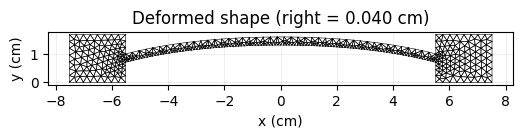


STEP 2/10: left = -0.04000 cm, right = 0.04000 cm
  Newton iterations: 4 Converged: True
  Wrote arch_blocks_0002.vtu


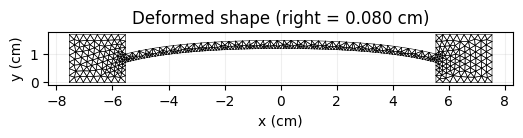


STEP 3/10: left = -0.06000 cm, right = 0.06000 cm
  Newton iterations: 4 Converged: True
  Wrote arch_blocks_0003.vtu


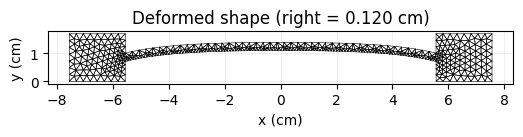


STEP 4/10: left = -0.08000 cm, right = 0.08000 cm
  Newton iterations: 4 Converged: True
  Wrote arch_blocks_0004.vtu


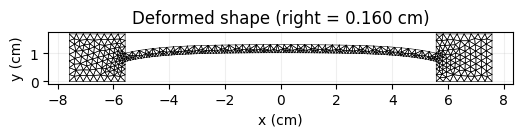


STEP 5/10: left = -0.10000 cm, right = 0.10000 cm
  Newton iterations: 4 Converged: True
  Wrote arch_blocks_0005.vtu


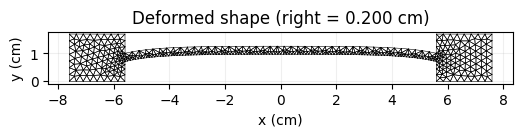


STEP 6/10: left = -0.12000 cm, right = 0.12000 cm
  Newton iterations: 4 Converged: True
  Wrote arch_blocks_0006.vtu


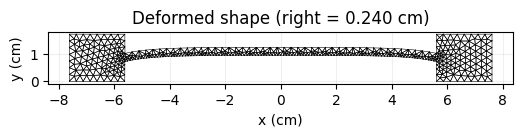


STEP 7/10: left = -0.14000 cm, right = 0.14000 cm
  Newton iterations: 4 Converged: True
  Wrote arch_blocks_0007.vtu


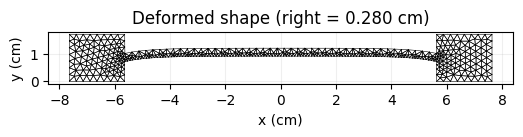


STEP 8/10: left = -0.16000 cm, right = 0.16000 cm
  Newton iterations: 4 Converged: True
  Wrote arch_blocks_0008.vtu


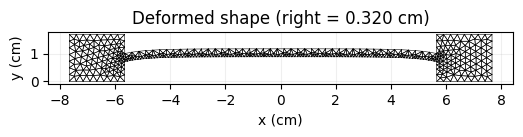


STEP 9/10: left = -0.18000 cm, right = 0.18000 cm
  Newton iterations: 4 Converged: True
  Wrote arch_blocks_0009.vtu


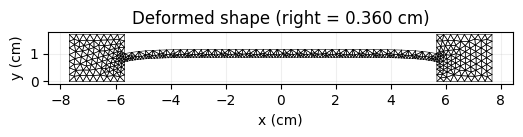


STEP 10/10: left = -0.20000 cm, right = 0.20000 cm
  Newton iterations: 3 Converged: True
  Wrote arch_blocks_0010.vtu


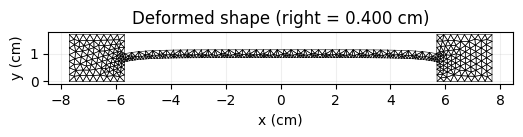


Wrote 10 VTU files and collection arch_blocks.pvd


In [10]:
u.x.array[:] = 0.0
u.name = "u"

base = "arch_blocks"
pvd_filename = f"{base}.pvd"
vtk_files = []   # (t, filename) pairs

for step in range(1, n_steps + 1):
    t = step / n_steps
    U_step = t * U_total   # total opening between blocks

    # symmetric motion: each block moves half the total, in opposite directions
    u_left_x.value  = -U_step / 2.0
    u_right_x.value =  U_step / 2.0

    print(f"\nSTEP {step}/{n_steps}: left = {-U_step/2:.5f} cm, right = {U_step/2:.5f} cm")

    its, converged = solver.solve(u)
    print("  Newton iterations:", its, "Converged:", converged)
    if not converged:
        print("  !!! Newton did not converge; stopping.")
        break

    # Displacement (N,2)
    u_vals = u.x.array.reshape(-1, 2)

    # Deformed coordinates (N,3): add ux,uy to x,y
    coords_def = coords_ref.copy()
    coords_def[:, 0] += u_vals[:, 0]
    coords_def[:, 1] += u_vals[:, 1]

    # Pad displacement to 3D
    u_3d = np.column_stack([u_vals, np.zeros(u_vals.shape[0])])

    # MeshIO cells: DO NOT overwrite 'cells' used by plot_deformed
    cells_mio = [("triangle", cells_tri.astype(np.int32))]

    vtk_name = f"{base}_{step:04d}.vtu"
    vtk_files.append((t, vtk_name))

    mesh = meshio.Mesh(points=coords_def,
                       cells=cells_mio,
                       point_data={"u": u_3d})
    meshio.write(vtk_name, mesh)
    print(f"  Wrote {vtk_name}")

    # Optional: show this step in the notebook
    plot_deformed(u, scale=1.0,
                  title=f"Deformed shape (right = {U_step:.3f} cm)")

# Write PVD collection referencing all VTU files
with open(pvd_filename, "w") as f:
    f.write('<?xml version="1.0"?>\n')
    f.write('<VTKFile type="Collection" version="0.1" byte_order="LittleEndian">\n')
    f.write('  <Collection>\n')
    for t, fname in vtk_files:
        f.write(f'    <DataSet timestep="{t:.8e}" group="" part="0" file="{fname}"/>\n')
    f.write('  </Collection>\n')
    f.write('</VTKFile>\n')

print(f"\nWrote {len(vtk_files)} VTU files and collection {pvd_filename}")
